<a href="https://www.kaggle.com/pjbhaumik/flexible-ensembling-pipeline?scriptVersionId=89221159" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# revised ensembling from https://www.kaggle.com/viktorbarbarich/linear-regression-baseline
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold

# Import dependencies and begin ETL

In [2]:
%%time
data = pd.read_pickle('../input/ump-train-picklefile/train.pkl')
data.drop(columns = ['row_id'], inplace = True) #row id is the time_id and investment_id joined using '-'

CPU times: user 2.02 s, sys: 7.3 s, total: 9.32 s
Wall time: 42 s


# Let's plot the trajectory of some investments

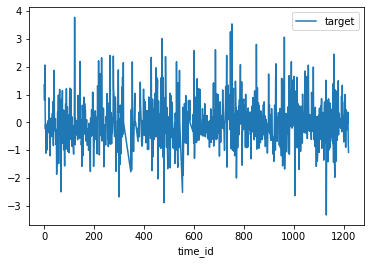

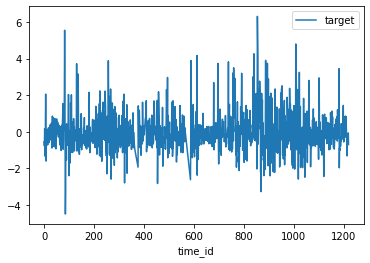

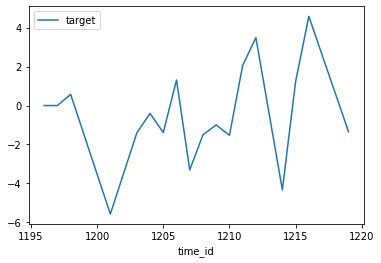

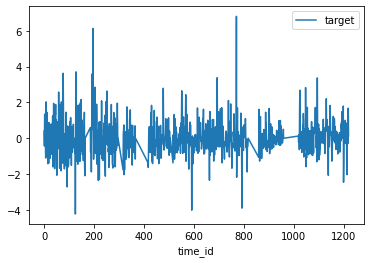

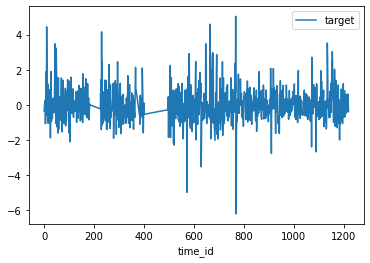

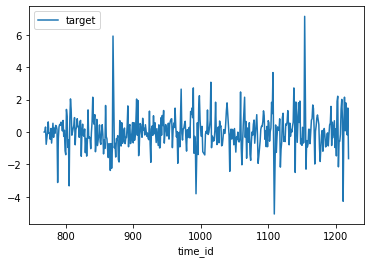

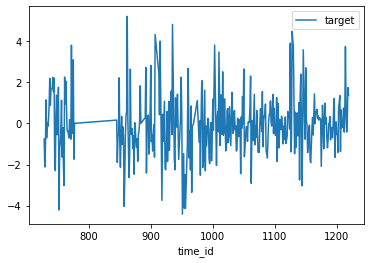

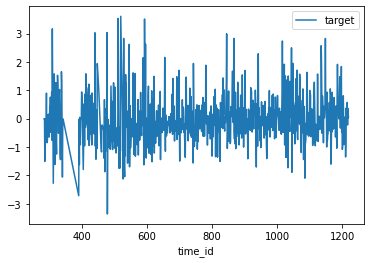

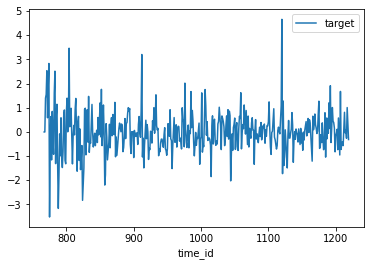

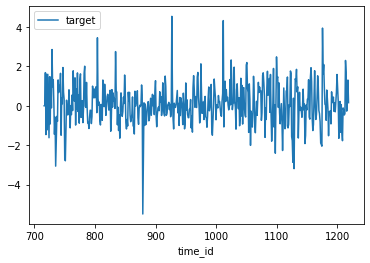

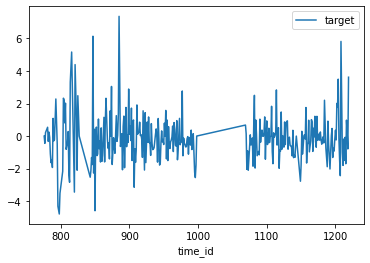

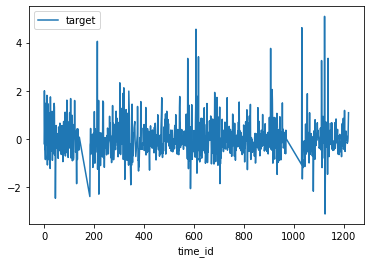

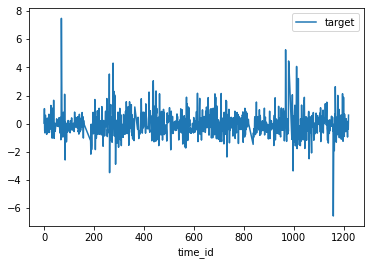

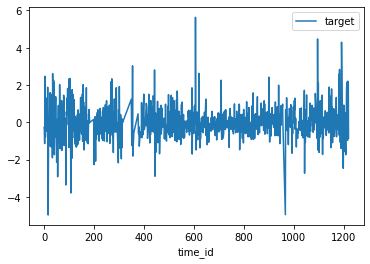

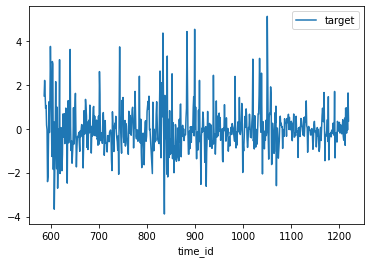

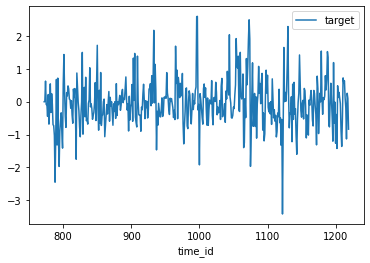

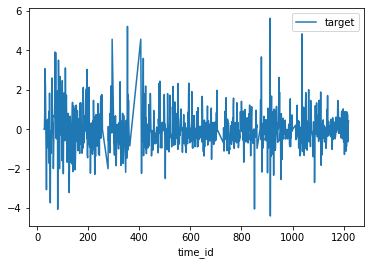

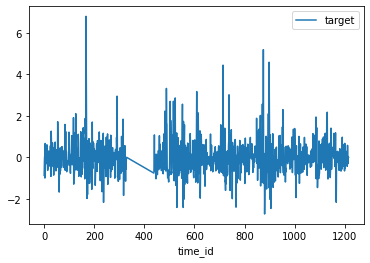

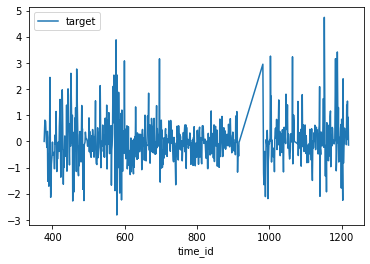

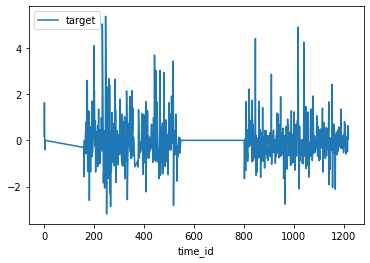

In [3]:
%matplotlib inline

for investment in np.random.choice(pd.unique(data['investment_id']), 20):
    data[data['investment_id']==investment].plot('time_id', 'target')

# Data Pre-processing

In [4]:
y = data.pop('target')
X = data
X.describe()

,time_id,investment_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
count,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,...,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06
mean,6.654862e+02,1.885265e+03,1.637057e-03,-1.257678e-02,8.514749e-03,-2.003703e-02,-5.416438e-03,-3.034008e-03,1.934330e-03,5.898536e-03,...,1.256709e-02,9.002053e-04,-6.509154e-03,2.851608e-03,-4.730820e-03,-2.773806e-02,-1.517383e-03,-7.057928e-03,-4.216896e-03,-4.319488e-03
std,3.560434e+02,1.083616e+03,1.079721e+00,1.030980e+00,1.030281e+00,9.602916e-01,9.895188e-01,1.104578e+00,1.067755e+00,1.004578e+00,...,1.084496e+00,1.114387e+00,1.070176e+00,1.101158e+00,1.144516e+00,9.592550e-01,1.140459e+00,1.108097e+00,1.051252e+00,1.008220e+00
min,0.000000e+00,0.000000e+00,-1.765789e+01,-6.579473e+00,-8.644268e+00,-1.800427e+01,-4.000015e+00,-8.833704e+00,-6.384251e+00,-1.394807e+01,...,-9.271487e+00,-6.359966e+00,-8.183732e+00,-2.399478e+01,-1.497270e+01,-9.348986e+00,-7.366648e+00,-7.579406e+00,-6.707284e+00,-1.028264e+01
25%,3.530000e+02,9.520000e+02,-4.071441e-01,-6.813878e-01,-6.530838e-01,-4.496046e-01,-3.532303e-01,-7.070855e-01,-7.911198e-01,-6.300225e-01,...,-6.037326e-01,-8.355157e-01,-6.981400e-01,-1.377131e-01,-9.397985e-01,-5.147926e-01,-9.573807e-01,-7.239380e-01,-8.165390e-01,-5.080143e-01
50%,7.040000e+02,1.882000e+03,2.431158e-01,-4.867587e-02,4.350941e-02,-2.639937e-01,-1.908876e-01,-2.144796e-02,1.437945e-02,-5.882107e-02,...,6.086323e-02,-2.023181e-01,-1.910102e-01,2.164071e-01,2.087202e-01,-2.907780e-01,6.955573e-03,-1.650222e-01,2.300689e-02,-2.824031e-01
75%,9.750000e+02,2.830000e+03,6.649507e-01,6.086557e-01,6.587324e-01,7.763371e-02,2.784694e-02,6.835684e-01,8.008306e-01,6.883256e-01,...,6.882384e-01,9.035954e-01,4.841421e-01,5.088849e-01,8.616266e-01,1.275946e-01,9.503851e-01,6.098197e-01,7.984827e-01,1.411301e-01
max,1.219000e+03,3.773000e+03,7.845261e+00,8.707207e+00,8.009340e+00,4.706333e+01,7.662866e+01,7.646200e+00,6.778142e+00,5.721995e+00,...,9.298274e+00,9.725060e+00,2.231185e+01,6.587691e+00,6.978151e+00,6.140367e+01,7.679950e+00,1.241804e+01,7.003982e+00,4.337021e+01


# Features appear already scaled with mean ~ 0 and std dev ~ 1, so there is no need to scale them.

In [5]:
X['time_id'].value_counts()

1214    3445
1209    3444
1211    3440
1207    3440
1208    3438
        ... 
415      659
362      651
374      600
398      539
492      512
Name: time_id, Length: 1211, dtype: int64

# There are 1211 different time steps with varying numbers of investments per time step.

In [6]:
X['investment_id'].value_counts()

2140    1211
2385    1209
1062    1209
1144    1209
2727    1209
        ... 
905        8
2558       8
3662       7
2800       3
1415       2
Name: investment_id, Length: 3579, dtype: int64

# There are 3579 different investments

In [7]:
# from sklearn.decomposition import IncrementalPCA

# transformer = IncrementalPCA(n_components=10)
# transformer.partial_fit(X)
# X = transformer.transform(X)

# Neither PCA nor incremental PCA works within the memory limits of this kernel. Unsupervised dimensionality reduction may be an option later... 

# Let's train models for ensembling using Stratified K folding to maintain the distribution of time steps per sample.

In [8]:
CNT_MODELS = 30 # 30 linear models

models = []

for i in range(0, CNT_MODELS):
    X_s = X.loc[i::CNT_MODELS]
    y_s = y.loc[X_s.index]
    models.append(LinearRegression().fit(X_s, y_s))


# Let's stack the models creating a meta model.

In [9]:
df = pd.DataFrame(columns=np.arange(len(models)))

for i, model in enumerate(models):
    df[i]=model.predict(X)

regr = LinearRegression().fit(df.values, y)

# Predict values. First predict from each model in the ensemble. Finally, use those predictions as input into the meta model.

In [10]:
import ubiquant
env = ubiquant.make_env()
iter_test = env.iter_test()
i = 0

for (test_df, sample_prediction_df) in iter_test:
    test_df.reset_index(inplace = True)
    test_df.pop('row_id')
    test_df.rename(columns={'index':'time_id'}, inplace = True)
    test_df['time_id'] = i
    df = pd.DataFrame(columns=np.arange(len(models)))
    for i, model in enumerate(models):
        df[i] = model.predict(test_df.values)
    sample_prediction_df['target'] = regr.predict(df)
    env.predict(sample_prediction_df)
    i += 1

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
